In [ ]:
!pip install -q transformers datasets tokenizers

     |████████████████████████████████| 1.3MB 8.5MB/s 
     |████████████████████████████████| 153kB 16.1MB/s 
     |████████████████████████████████| 2.9MB 20.1MB/s 
     |████████████████████████████████| 1.1MB 49.3MB/s 
     |████████████████████████████████| 890kB 45.1MB/s 
     |████████████████████████████████| 245kB 52.6MB/s 
     |████████████████████████████████| 17.7MB 208kB/s 
ERROR: transformers 3.5.1 has requirement tokenizers==0.9.3, but you'll have tokenizers 0.9.4 which is incompatible.


# Домашнее задание. Transformers.

Привет! Это очередное домашнее задание, но теперь ты познакомишься с моделя трансформеров и с библиотекой `HuggingFace🤗`. В этом задании будет предложено решить с помощью модели `GPT2` простую задачу (анализ сентимента) и сделать небольшое исследование карт внимания. Приступим!

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

import torch
import torch.nn as nn

from transformers import GPT2ForSequenceClassification, GPT2TokenizerFast, GPT2Config
from datasets import load_dataset

In [ ]:
device = "cuda" if torch.cuda.is_available else "cpu"

Датасет, который мы будем использовать сегодня – тексты из английского твиттера. Они уже почищенны от никнеймов, знаков препинания и прочего. 

In [ ]:
emotion_dataset = load_dataset("emotion")

Using custom data configuration default


Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/5276a3f9a2c014ee528f5cca7ad34f185b886acd0f60fe18c61c6768662ca828. Subsequent calls will reuse this data.


Посмотри, из чего состоит `emotion_dataset`:

In [ ]:
emotion_dataset

DatasetDict({'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000), 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000), 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)})

In [ ]:
emotion_dataset["train"]

Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000)

In [ ]:
emotion_dataset["train"]["text"][0]

'i didnt feel humiliated'

In [ ]:
emotion_dataset["train"]["label"][0]

'sadness'

In [ ]:
len(emotion_dataset["train"])

16000

Для перевода текста в токены мы будем использовать предобученный BPE-токенайзер.

In [ ]:
tokenizer = GPT2TokenizerFast.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token # У gpt2 нет pad токенов. Вместо них воспользуемся токенами конца текста.

Подготовь класс, который принимает датасет, токенайзер и имя используемой части (`train`, `validation`, `test`). Используй его для получения данных для обучения.

P.S. Посмотри, как работает токенайзер ([docs](https://huggingface.co/transformers/main_classes/tokenizer.html)) и подумай, как его надо добавить в датасет.

Немного примеров, как работает токенайзер. Это поможет с написанием датасета.

In [ ]:
tokenizer.tokenize(emotion_dataset["train"]["text"][0])

['i', 'Ġdidnt', 'Ġfeel', 'Ġhumiliated']

In [ ]:
tokenizer.encode(emotion_dataset["train"]["text"][0])

[72, 42547, 1254, 42659]

In [ ]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0])

{'input_ids': [72, 42547, 1254, 42659], 'attention_mask': [1, 1, 1, 1]}

In [ ]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0], return_tensors="pt")

{'input_ids': tensor([[   72, 42547,  1254, 42659]]), 'attention_mask': tensor([[1, 1, 1, 1]])}

In [ ]:
tokenizer.encode_plus(
    emotion_dataset["train"]["text"][0], 
    max_length=128, # максимальная длина текста
    padding="max_length", # надо ли добавлять паддинг в конце?
    return_tensors="pt", # возвращает pytorch тензоры
)

{'input_ids': tensor([[   72, 42547,  1254, 42659, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 5

In [ ]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, part, dataset=emotion_dataset, tokenizer=tokenizer, max_length=128):
        self.part = part
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        self.labels = np.unique(dataset[part]["label"])
        self.label2num = {l: num for num, l in enumerate(self.labels)}
        
    def __getitem__(self, idx):
        """
        Return dict with tokens, attention_mask and label
        """
        text = emotion_dataset[self.part]["text"][idx]
        label = emotion_dataset[self.part]["label"][idx]
        #encoding = tokenizer(emotion_dataset[self.part]["text"][idx],
                             #return_tensors='pt', padding=True,

                             #)
        #target =[]
        #tokenizer_output = tokenizer.encode_plus(text,return_tensors='pt',
                                                 #padding = True,
                                                 #truncation = True)
        

        tokenizer_output = tokenizer.encode_plus(text, return_tensors='pt',
                                                 max_length=128,
                                                 padding="max_length")

        target= self.label2num[label]
        target = torch.from_numpy(np.array(target))
        return {
            "input_ids": tokenizer_output['input_ids'].squeeze(0), 
            "mask": tokenizer_output['attention_mask'].squeeze(0),
            "target": target
        }
        
    def __len__(self):
        """
        Return length of dataset
        """
        return len(self.dataset[self.part])

Создай `train`, `validation` и `test` части датасета. Загрузи их в `DataLoaders`.

In [ ]:
train_dataset = TweetDataset('train')
valid_dataset = TweetDataset('validation')
test_dataset = TweetDataset('test')

In [ ]:
batch_size = 32 # Задай batch_size

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size, shuffle = True
)
valid_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size, shuffle = False
)
test_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size, shuffle = False,
)

## Начнем с нуля.

Попробуем обучить модель трансформер с нуля решать данную задачу.

In [ ]:
config = GPT2Config.from_pretrained(
    "distilgpt2", # distilgpt2 – уменьшенная версия модели gpt2
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=6
)
model_0 = GPT2ForSequenceClassification(config=config).to(device) # GPT2 для классификации текста

Подготовь оптимайзер и критерий:

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup
lr = 1e-5 # Предполагаемый learning rate. Он может быть больше или меньше :)
total_steps = len(train_loader) * 10
optimizer = AdamW(model_0.parameters(),
                  lr = lr,
                  eps = 1e-8
                )
#criterion = ...
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 1e2, 
                                            num_training_steps = total_steps)

Посмотри, что возвращает модель ([docs](https://huggingface.co/transformers/model_doc/gpt2.html#gpt2forsequenceclassification)), если в неё подать данные:

In [ ]:
tokens = x['input_ids'].to(device) # Получи токены из датасета
mask = x['mask'].to(device) # Получи маску из датасета

outputs = model_0(input_ids=tokens, attention_mask=mask, labels = x['target'].to(device), return_dict=True) # Посмотри на аутпут

Обучи модель с помощью `train_dataset`, проверяй во время обучения качество с помощью `valid_dataset` и получи финальное качество с помощью `test_dataset`.

In [ ]:
from tqdm.notebook import tqdm


num_epochs = 10

# Train loop
for e in range(num_epochs):
    model_0.train()
    train_loss = 0
    i=0
    for batch in tqdm(train_loader):
      optimizer.zero_grad()

      outputs = model_0(input_ids = batch['input_ids'].to(device),
                        attention_mask = batch['mask'].to(device),
                        labels = batch['target'].to(device),
                        )
      
      outputs[0].backward()
      optimizer.step()
      scheduler.step()

      train_loss += outputs[0]
      
        
    valid_loss = 0
    valid_acc = 0
    model_0.eval()
    ii=0
    with torch.no_grad():
        for batch in valid_loader: 

          outputs = model_0(input_ids = batch['input_ids'].to(device),
                        attention_mask = batch['mask'].to(device),
                        labels = batch['target'].to(device),
                        return_dict = True
                        )
          
          valid_loss += outputs.loss
          class_ = outputs.logits.detach().cpu()
          class_ = np.argmax(class_, axis = 1)
          
          valid_acc += (np.array(sum(batch['target'] == class_)))/len(batch['target'])
    print(f"Train Loss: {np.array(train_loss.detach().cpu()) / len(train_loader)},"
          f"Valid Loss: {np.array(valid_loss.detach().cpu()) / len(valid_loader)},"
          f"Valid Acc: {valid_acc / len(valid_loader)}")
        
# Testing
test_acc = 0
model_0.eval()
with torch.no_grad():
    for batch in test_loader:
    
        outputs = model_0(input_ids = batch['input_ids'].to(device),
                        attention_mask = batch['mask'].to(device),
                        labels = batch['target'].to(device),
                        return_dict = True
                        )
          
        class_ = outputs.logits.detach().cpu()
        class_ = np.argmax(class_, axis = 1)
          
        test_acc += (np.array(sum(batch['target'] == class_)))/len(batch['target'])
        
print(f"Test Acc: {test_acc / len(test_loader)}")


Train Loss: 1.59382861328125,Valid Loss: 1.45616796875,Valid Acc: 0.4246875



Train Loss: 1.409257080078125,Valid Loss: 1.0805191650390624,Valid Acc: 0.5955



Train Loss: 1.08366552734375,Valid Loss: 0.6729378051757813,Valid Acc: 0.75875



Train Loss: 0.8195604248046875,Valid Loss: 0.44768682861328124,Valid Acc: 0.846125



Train Loss: 0.6476364135742188,Valid Loss: 0.30349945068359374,Valid Acc: 0.8946875



Train Loss: 0.5428514404296875,Valid Loss: 0.22965415954589843,Valid Acc: 0.922625



Train Loss: 0.4649996032714844,Valid Loss: 0.1820487823486328,Valid Acc: 0.940375



Train Loss: 0.423955322265625,Valid Loss: 0.15890782165527345,Valid Acc: 0.948625



Train Loss: 0.38254446411132814,Valid Loss: 0.14473985290527344,Valid Acc: 0.9520625



Train Loss: 0.3547554016113281,Valid Loss: 0.13721697998046875,Valid Acc: 0.9548125
Test Acc: 0.9548125


После того, как получил лучшую модель для решения этой задачи, посмотри на карты внимания. Нашел ли что-нибудь интересное в них?

In [ ]:
def get_attention_matrixes(model, tokenizer, text, device=device):
    inp = list(filter(lambda x: x != tokenizer.sep_token_id, tokenizer.encode(text)))
    inp = torch.tensor(inp, dtype=torch.long, device=device).unsqueeze(0)
    attn_tensors = model(inp)[-1]
    seq = [tokenizer.decode(x) for x in inp[0].tolist()]
    attn = []
    for i in range(len(attn_tensors)):
        attn_layer = []
        for j in range(attn_tensors[i].size(1)):
            attn_layer.append(attn_tensors[i][0, j].cpu().detach().numpy())
        attn.append(np.array(attn_layer))
    
    return np.array(attn)

In [ ]:
def show_attention(seq, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions)
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels(['']+seq, rotation=90, fontsize=16)
    ax.set_yticklabels(['']+seq, fontsize=16)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [ ]:
text = emotion_dataset["train"]["text"][3] # Выбери текст из датасета
tokens = tokenizer.tokenize(text)

In [ ]:
tokens

['i',
 'Ġam',
 'Ġever',
 'Ġfeeling',
 'Ġnostalgic',
 'Ġabout',
 'Ġthe',
 'Ġfireplace',
 'Ġi',
 'Ġwill',
 'Ġknow',
 'Ġthat',
 'Ġit',
 'Ġis',
 'Ġstill',
 'Ġon',
 'Ġthe',
 'Ġproperty']

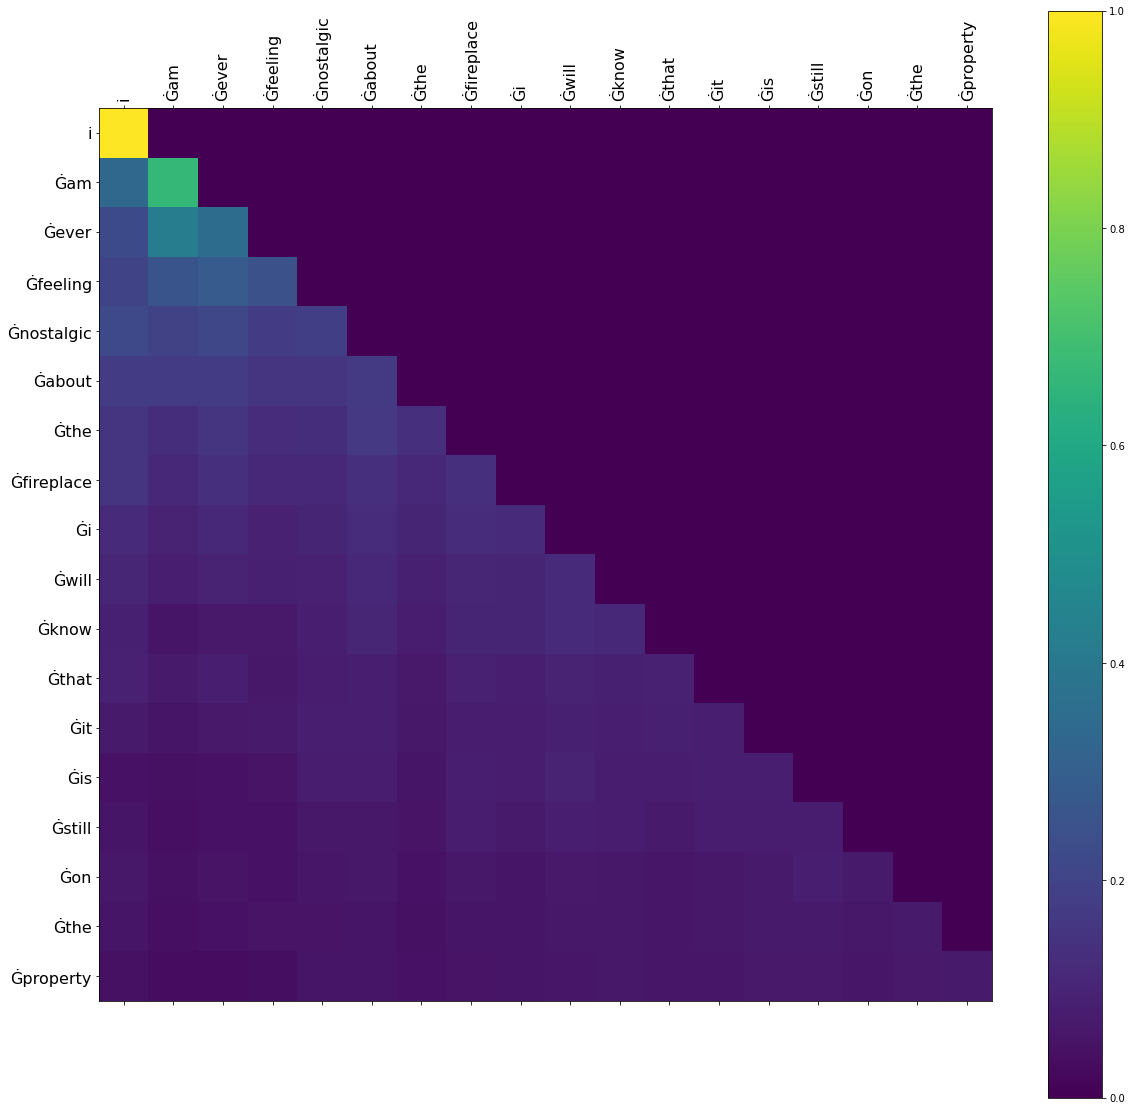

In [ ]:
attns = get_attention_matrixes(model_0, tokenizer, text)
show_attention(tokens, attns[-1][0])

## Fine-tuning

Теперь другой подход: загрузим модель, которая обучалась решать задачу Language Modeling. Посмотрим, получим ли мы прирост в качестве.

In [ ]:
model_1 = GPT2ForSequenceClassification.from_pretrained(
    "distilgpt2", 
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=6
).to(device)

Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup
lr = 1e-5 # Предполагаемый learning rate. Он может быть больше или меньше :)
total_steps = len(train_loader) * 10
optimizer = AdamW(model_1.parameters(),
                  lr = lr,
                  eps = 1e-8
                )
#criterion = ...
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 1e2, 
                                            num_training_steps = total_steps)

Вывод модели ничем не отличается от предыдущего случая, поэтому сразу приступаем к обучению:

In [ ]:
from tqdm.notebook import tqdm


num_epochs = 5

# Train loop
for e in range(num_epochs):
    model_1.train()
    train_loss = 0
    i=0
    for batch in tqdm(train_loader):
      optimizer.zero_grad()

      outputs = model_1(input_ids = batch['input_ids'].to(device),
                        attention_mask = batch['mask'].to(device),
                        labels = batch['target'].to(device),
                        )
      
      outputs[0].backward()
      optimizer.step()
      scheduler.step()

      train_loss += outputs[0]
      
        
    valid_loss = 0
    valid_acc = 0
    model_1.eval()
    ii=0
    with torch.no_grad():
        for batch in valid_loader: 

          outputs = model_1(input_ids = batch['input_ids'].to(device),
                        attention_mask = batch['mask'].to(device),
                        labels = batch['target'].to(device),
                        return_dict = True
                        )
          
          valid_loss += outputs.loss
          class_ = outputs.logits.detach().cpu()
          class_ = np.argmax(class_, axis = 1)
          
          valid_acc += (np.array(sum(batch['target'] == class_)))/len(batch['target'])
    print(f"Train Loss: {np.array(train_loss.detach().cpu()) / len(train_loader)},"
          f"Valid Loss: {np.array(valid_loss.detach().cpu()) / len(valid_loader)},"
          f"Valid Acc: {valid_acc / len(valid_loader)}")
        
# Testing
test_acc = 0
model_1.eval()
with torch.no_grad():
    for batch in test_loader:
    
        outputs = model_1(input_ids = batch['input_ids'].to(device),
                        attention_mask = batch['mask'].to(device),
                        labels = batch['target'].to(device),
                        return_dict = True
                        )
          
        class_ = outputs.logits.detach().cpu()
        class_ = np.argmax(class_, axis = 1)
          
        test_acc += (np.array(sum(batch['target'] == class_)))/len(batch['target'])
        
print(f"Test Acc: {test_acc / len(test_loader)}")


Train Loss: 2.164951171875,Valid Loss: 1.1698997802734374,Valid Acc: 0.5713125



Train Loss: 0.828272216796875,Valid Loss: 0.4247843627929688,Valid Acc: 0.8556875



Train Loss: 0.401634521484375,Valid Loss: 0.22986567687988282,Valid Acc: 0.9103125



Train Loss: 0.2740908203125,Valid Loss: 0.15832264709472657,Valid Acc: 0.9335



Train Loss: 0.22366737365722655,Valid Loss: 0.13591444396972657,Valid Acc: 0.938875
Test Acc: 0.938875


Есть ли прирост качества или скорости обучения?

Посмотри на карты внимания. Есть ли отличие от предыдущего случая?

In [ ]:
text = emotion_dataset["train"]["text"][0] # Выбери текст из датасета
tokens = tokenizer.tokenize(text)

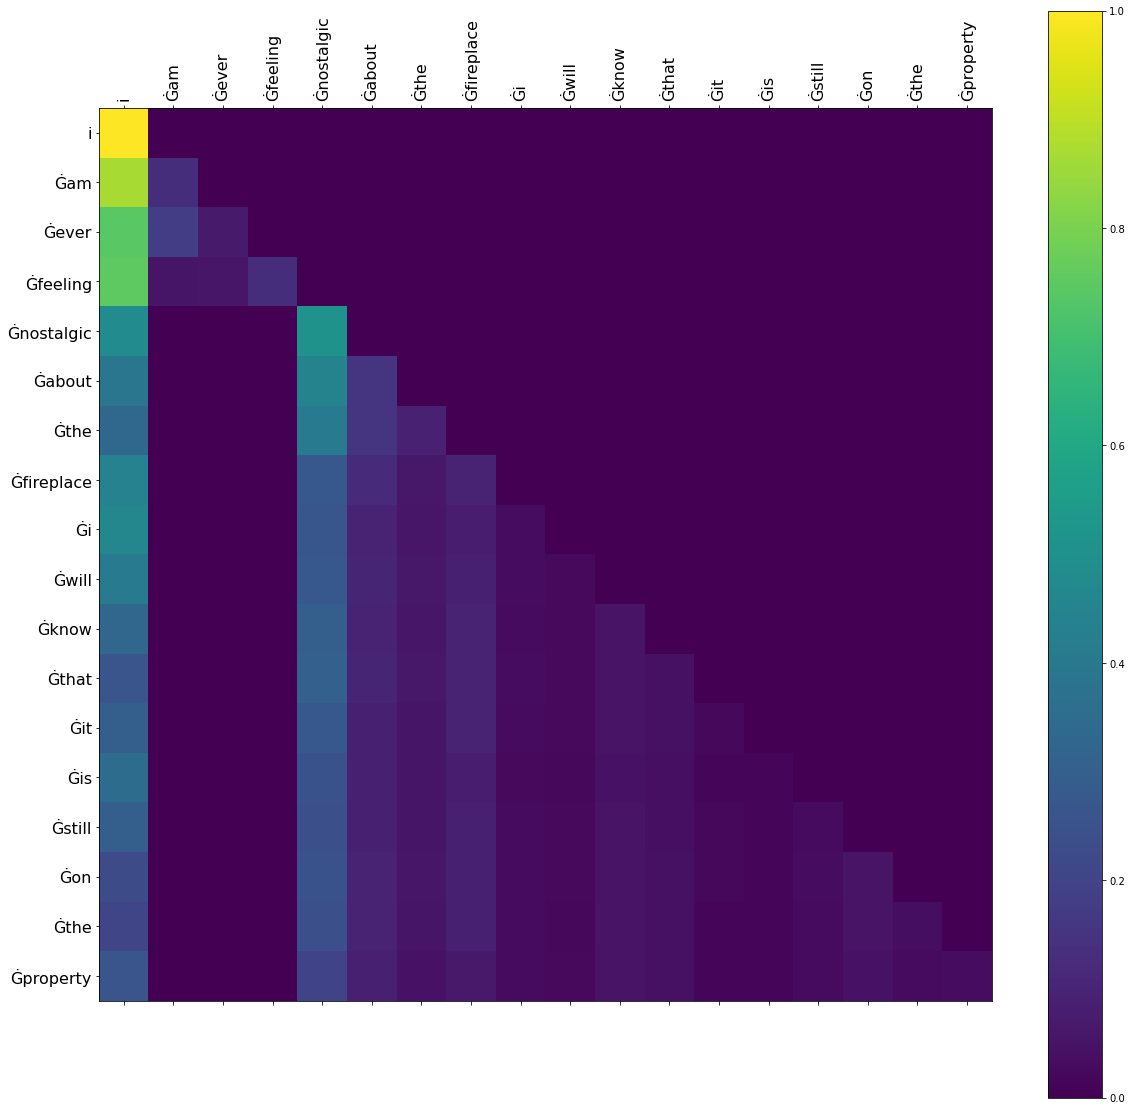

In [ ]:
attns = get_attention_matrixes(model_1, tokenizer, text)
show_attention(tokens, attns[-1][0])

## Отчет

Покажи здесь, что ты выполнил по этой работе. Ответь на несколько вопросов:
- Какой подход оказался лучше? 
- На какие слова модель большего всего обращала внимание?
- На каких слоях/головах модель обращала внимание?

< твой отчет/ответы >

С pre-train моделью, для достижения одинаковых показателей точности - потребовалось в 2 раза меньше времени.
Так же, карта внимания pre-train модели более ярко выраженная, если в первой модели слово в основном смотрела сама на себя, то здесь видно что слова контекста имеют больший вес чем само слово. Отсутвуют слои где слова "соеденены" вниманием друг на друга.

In [ ]:
attns.shape

(6, 12, 18, 18)

In [ ]:
import sys
!test -d bertviz_repo && echo "FYI: bertviz_repo directory already exists, to pull latest version uncomment this line: !rm -r bertviz_repo"
# !rm -r bertviz_repo # Uncomment if you need a clean pull from repo
!test -d bertviz_repo || git clone https://github.com/jessevig/bertviz bertviz_repo
if not 'bertviz_repo' in sys.path:
  sys.path += ['bertviz_repo']
!pip install regex

Cloning into 'bertviz_repo'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 1077 (delta 0), reused 2 (delta 0), pack-reused 1074
Receiving objects: 100% (1077/1077), 100.00 MiB | 23.64 MiB/s, done.
Resolving deltas: 100% (687/687), done.


In [ ]:
from bertviz import model_view

In [ ]:
def call_html():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/5.7.0/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))

In [ ]:
x = next(iter(train_dataset))

In [ ]:
input_ids = x['input_ids'].unsqueeze(0)

In [ ]:
mask = x['mask'].unsqueeze(0)

In [ ]:
outputs = model_1(input_ids = input_ids.to(device),attention_mask = mask.to(device),labels = x['target'].to(device))

In [ ]:
 outputs[-1][0].shape

torch.Size([1, 12, 128, 128])

In [ ]:
#text = text
#inputs = tokens
#input_ids = input_ids
#attention = attns
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)
call_html()
model_view(outputs[-1], tokens)